# SENTIMENT ANALYSIS OF AIRLINE TWEETS

# Business Understanding

## Overview
In the highly competitive airline industry, leveraging sentiment analysis can provide a competitive edge. By analyzing various sources of customer feedback, such as social media posts, sentiment analysis can determine whether the sentiment of the feedback is positive, negative, or neutral. This can provide valuable insights into customers' opinions and preferences, aid in identifying common complaints, monitor trends in customer feedback, and enable the development of targeted strategies to enhance customer satisfaction and loyalty. Employing sentiment analysis can lead to data-driven decisions, improving overall performance and reputation, and resulting in increased profitability and success.

## Business Problem

The airline industry faces various challenges, including high operational costs, security concerns, environmental impact, and fierce competition. In Kenya, for example, the national carrier Kenya Airways has been struggling financially as a result of some of these challenges. To remain competitive in such a challenging environment, airlines need to find innovative ways to improve their service offerings while keeping operational costs low. One way to achieve this is by leveraging sentiment analysis to better understand customer preferences and improve overall customer satisfaction.<br>
Therefore, we aim to use Natural Language Processing (NLP) to provide valuable insights into customer preferences and improve the overall customer experience which will consequently improve the airline's competitiveness.

## Objectives

To build a machine learning model that accurately predicts the sentiment of airline passengers based on their tweets.

### Specific objectives

1.	To use NLP techniques to preprocess and clean the customer feedback dataset to prepare it for sentiment analysis.
2.	To apply sentiment analysis techniques to categorize the customer feedback into positive, negative, or neutral sentiments.
3.	To determine the model’s effectiveness in predicting the sentiment of airline passengers based on recall and F1-score metrics.
4.	To interpret the model results and gain insights into the factors that influence customer satisfaction and dissatisfaction with the airline.


## Success Criteria

A model will be considered a success when it is able to correctly identify all tweets with positive, negative or neutral sentiment. For an airline, missing a tweet that expresses negative sentiment could lead to the airline missing an opportunity to address the issue and potentially lose a customer. Therefore, high recall is crucial in order to capture all relevant tweets expressing positive, negative or neutral sentiment, and take appropriate actions accordingly.<br>
However, a model with high recall may also classify a large number of irrelevant tweets as positive, which would lower its precision and potentially mislead the interpretation of the sentiment analysis results. F1 score will be used as a secondary metric, to provide a balance between recall and precision.

# Data Understanding

### Importing the Libraries

In [1]:
# uncomment to install
# !pip install folium
# !pip install textblob
# !pip install wordcloud
# !pip install scikeras[tensorflow]
# import nltk
# nltk.download('wordnet', quiet = True)
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore') 

In [2]:
#importing the relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import ast
import folium
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import tensorflow
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import RandomizedSearchCV

### Loading the Data

The airline_tweets dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment). Data was scraped from Twitter and contributors were asked to first classify positive, negative, and neutral tweets.

In [3]:
#load the data
url = 'https://raw.githubusercontent.com/Scholarchep/semantic-analysis-of-airline-tweets/b2298e25a2ae4add54c2ba41983f8497688c3ba9/data/airline_tweets.csv'
df = pd.read_csv(url)
columns = ['airline', 'name', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'airline_sentiment']
df = df[columns]

#preview the first five rows
df.head()

,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,airline_sentiment
0,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),neutral
1,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),positive
2,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),neutral
3,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),negative
4,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),negative


In [4]:
# number of rows and columns 
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 14640 rows and 9 columns


In [5]:
# summary information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline            14640 non-null  object
 1   name               14640 non-null  object
 2   retweet_count      14640 non-null  int64 
 3   text               14640 non-null  object
 4   tweet_coord        1019 non-null   object
 5   tweet_created      14640 non-null  object
 6   tweet_location     9907 non-null   object
 7   user_timezone      9820 non-null   object
 8   airline_sentiment  14640 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


### Mapping the tweets with coordinate values

In [6]:
# tweets with coordinate values
tweet_coord = df[df['tweet_coord'].isnull() == False]
tweet_coord['tweet_coord']

21        [40.74804263, -73.99295302]
28          [42.361016, -71.02000488]
29        [33.94540417, -118.4062472]
32       [33.94209449, -118.40410103]
34          [33.2145038, -96.9321504]
                     ...             
14577    [33.93939612, -118.38973148]
14596    [35.22534456, -106.57241352]
14612     [40.46692522, -82.64567078]
14624      [32.9070889, -97.03785947]
14625     [40.64946781, -73.76624703]
Name: tweet_coord, Length: 1019, dtype: object

In [7]:
# Define a function to filter ignore invalid coordinates
def parse_coord(coord_str):
    try:
        coord_list = ast.literal_eval(coord_str)
        if isinstance(coord_list, list) and len(coord_list) == 2:
            return coord_list
    except (SyntaxError, ValueError):
        pass
    return [0, 0]

# create a column with parsed coordinates
df['parsed_coord'] = df['tweet_coord'].apply(parse_coord)

In [8]:
# create a map object centered at the first coordinate
map_object = folium.Map(location=df['parsed_coord'].iloc[0], zoom_start=2, zoom_control=False)

sample_coord = df['parsed_coord'].sample(n=2000, random_state=42)
# loop over each coordinate sample in the column and create a marker for it
for coord in sample_coord:
    marker = folium.Marker(location=(coord[0], coord[1]))
    marker.add_to(map_object)

# display the map
map_object

Note: Most of the tweets with coordinates are from USA.

### Number of Tweets Per Airline

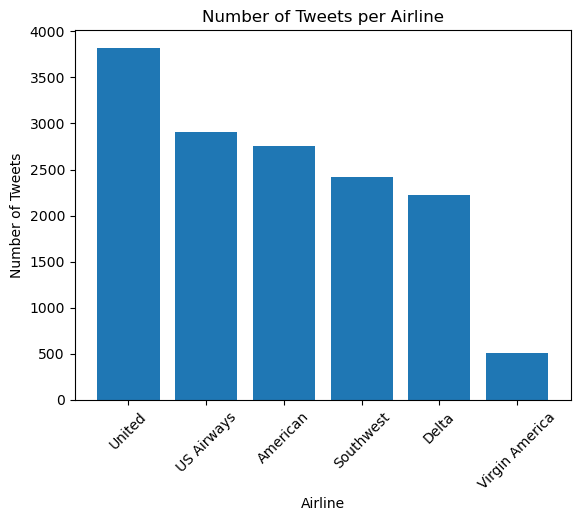

In [9]:
# Count the number of tweets per airline
tweets_per_airline = df['airline'].value_counts()

# Sort the values in descending order
tweets_per_airline = tweets_per_airline.sort_values(ascending=False)

# Plot the bar graph
plt.bar(tweets_per_airline.index, tweets_per_airline.values)
plt.title('Number of Tweets per Airline')
plt.xlabel('Airline')
plt.xticks(rotation=45)
plt.ylabel('Number of Tweets')
plt.show()

### Distribution of sentiment categories

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


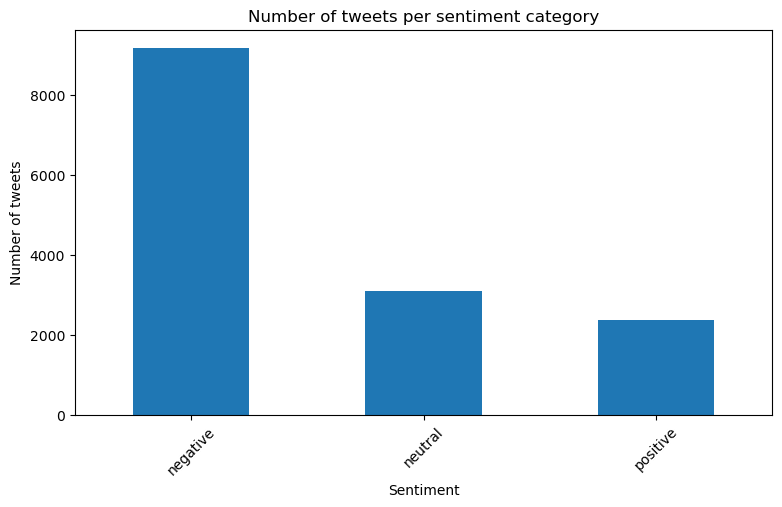

In [10]:
# Show the value counts
print(df['airline_sentiment'].value_counts())

# bar plot showing the sentiment categories
plt.subplots(figsize= (9, 5))
plt.title('Number of tweets per sentiment category')
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
df['airline_sentiment'].value_counts().plot(kind='bar')
plt.xticks(rotation=45);

### Displaying tweets trend over time

In [11]:
# Convert the tweet_created column to date-time
copy_df = df.copy()
copy_df['tweet_created'] = pd.to_datetime(copy_df['tweet_created'])
copy_df['tweet_created'].dtype

datetime64[ns, pytz.FixedOffset(-480)]

In [12]:
# print the range of dates
print('Earliest tweet:', copy_df['tweet_created'].min())
print('Latest tweet:', copy_df['tweet_created'].max())

Earliest tweet: 2015-02-16 23:36:05-08:00
Latest tweet: 2015-02-24 11:53:37-08:00


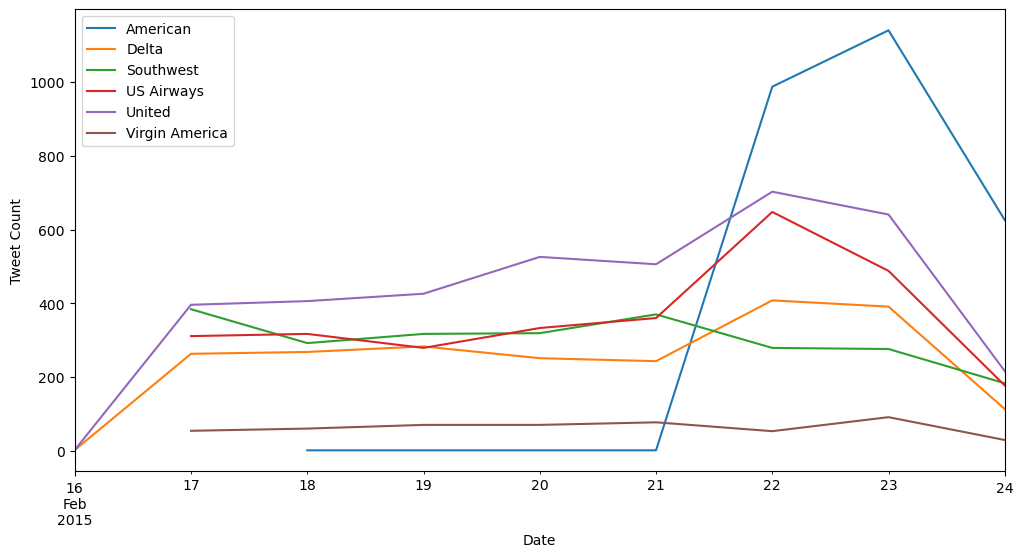

In [13]:
# group the data by airline and date, count the number of tweets
tweet_count = copy_df.groupby(['airline', pd.Grouper(key='tweet_created', freq='D')]).size().reset_index(name='count')

# plot a bar chart of the tweet count by airline and date
fig, ax = plt.subplots(figsize=(12,6))
for airline, values in tweet_count.groupby('airline'):
    ax = values.plot(x='tweet_created', y='count', ax=ax, label=airline)
    
ax.set_xlabel('Date')
ax.set_ylabel('Tweet Count')
ax.legend()
plt.show()


Note: There is a spike in the number of tweets on 21st February to 23rd.

### Tweets Word Cloud

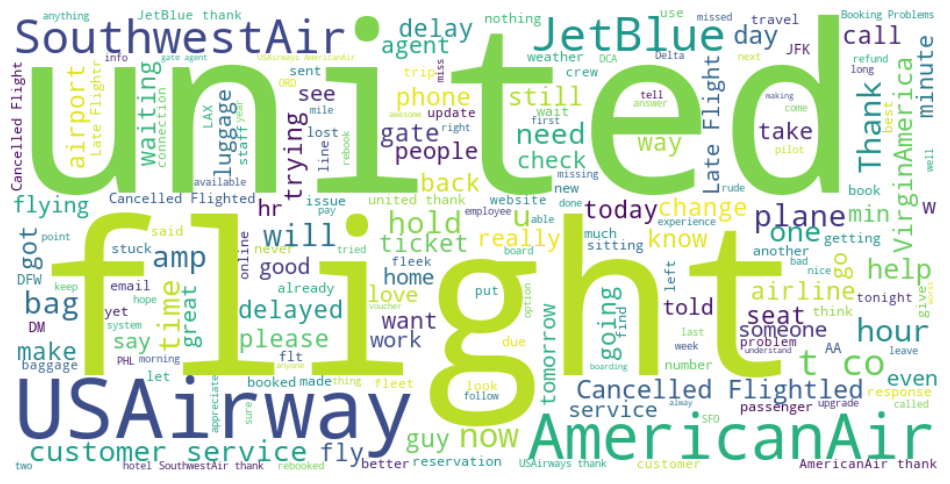

In [14]:
# Creating a word cloud of the tweets
# concatenate all the tweets into a single string
all_tweets = ' '.join(copy_df['text'].values)

# create a WordCloud object
wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_tweets)

# display the word cloud
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Note: The tags in the text have the highest frequency and removing them would provide a better understanding on the topics. However, time is prominent with variations such as hour, minute, late flight, now, and delay. Other frequest words or phrases are customer service, thank, cancelled, great, need.

# Data Preparation

In [15]:
# keep relevant columns
copy_df = copy_df[['airline', 'retweet_count', 'text', 'name', 'tweet_created', 'airline_sentiment']]

### Missing values

In [16]:
# check for missing values
copy_df.isna().sum()

airline              0
retweet_count        0
text                 0
name                 0
tweet_created        0
airline_sentiment    0
dtype: int64

### Checking for Duplicates

In [17]:
#check for duplicates
copy_df.duplicated(subset=['name', 'text', 'tweet_created']).sum()

155

In [18]:
# Preview the duplicated data
duplicated = copy_df[copy_df.duplicated(keep=False, subset=['name', 'text', 'tweet_created'])]
duplicated.sort_values(by='name') 

,airline,retweet_count,text,name,tweet_created,airline_sentiment
12060,American,0,@AmericanAir Do you have any sort of live chat...,AesaGaming,2015-02-24 11:29:54-08:00,neutral
12088,American,0,@AmericanAir Trying desperately to get my boyf...,AesaGaming,2015-02-24 10:58:03-08:00,neutral
11927,American,0,@AmericanAir Trying desperately to get my boyf...,AesaGaming,2015-02-24 10:58:03-08:00,negative
11899,American,0,@AmericanAir Do you have any sort of live chat...,AesaGaming,2015-02-24 11:29:54-08:00,neutral
12083,American,0,“@AmericanAir: @Andrew_Wasila We're sorry you ...,Andrew_Wasila,2015-02-24 11:01:29-08:00,negative
...,...,...,...,...,...,...
11902,American,0,.@AmericanAir just disappointed with the Fligh...,trentgillaspie,2015-02-24 11:24:57-08:00,neutral
12104,American,0,@AmericanAir OK I will call them likely tmrw U...,waynebevan,2015-02-24 10:31:54-08:00,neutral
11943,American,0,@AmericanAir OK I will call them likely tmrw U...,waynebevan,2015-02-24 10:31:54-08:00,neutral
12178,American,0,@AmericanAir It is now going to be reported to...,weezerandburnie,2015-02-24 09:06:55-08:00,negative


In [19]:
# Drop the Duplicated rows
copy_df = copy_df.drop_duplicates()
copy_df.duplicated().sum()

0

### Preprocessing of the text

Text data is usually very messy. This especially applies in a context like twitter where there a lot of variations to how people express themselves. Some may choose to use Emoticons, a sequence of characters that may resemble an Emoticon, different spellings, hyperlinks and so on in the expression of their feelings and ideas. We need to standardize this data to a somewhat general format that can be then used for analysis. 

Cleaning this data is a first step. Getting rid of unnecessary data like emoticons and links will aid in retaining the most relevant parts of the data that can then be used for the next step. To achieve this, we will use the 're' library, a regular expression library.

In [20]:
#define function to remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


#Remove mentions, #, :, _, apostrophes, hyperlinks, emojis
def cleanText(text):
    pattern =(r'@[A-Za-z0-9]+|#|:|_|\'|http\S+|RT[\s]+')
    text = re.sub(pattern, '', text)
    text = remove_emoji(text)
    return text

copy_df['cleaned_text']=copy_df['text'].apply(cleanText)
copy_df['cleaned_text']

0                                              What  said.
1         plus youve added commercials to the experienc...
2         I didnt today... Must mean I need to take ano...
3         its really aggressive to blast obnoxious "ent...
4                  and its a really big bad thing about it
                               ...                        
14635     thank you we got on a different flight to Chi...
14636     leaving over 20 minutes Late Flight. No warni...
14637       Please bring American Airlines to BlackBerry10
14638     you have my money, you change my flight, and ...
14639     we have 8 ppl so we need 2 know how many seat...
Name: cleaned_text, Length: 14503, dtype: object

In [32]:
# Define function to preprocess text
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
def preprocess_text(text):
    # Tokenize text into individual words
    tokens = tokenizer.tokenize(text.lower())
    # Remove stop words
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_removed = [token for token in tokens if token not in stopwords_list]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stopwords_removed]
    # Join tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

# apply the preprocessing function
copy_df['preprocessed_text'] = copy_df['cleaned_text'].apply(lambda x: preprocess_text(x))
copy_df['preprocessed_text']

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight warning communicati...
14637           please bring american airline blackberry10
14638    money change flight dont answer phone suggesti...
14639    ppl need know many seat next flight plz put st...
Name: preprocessed_text, Length: 14503, dtype: object

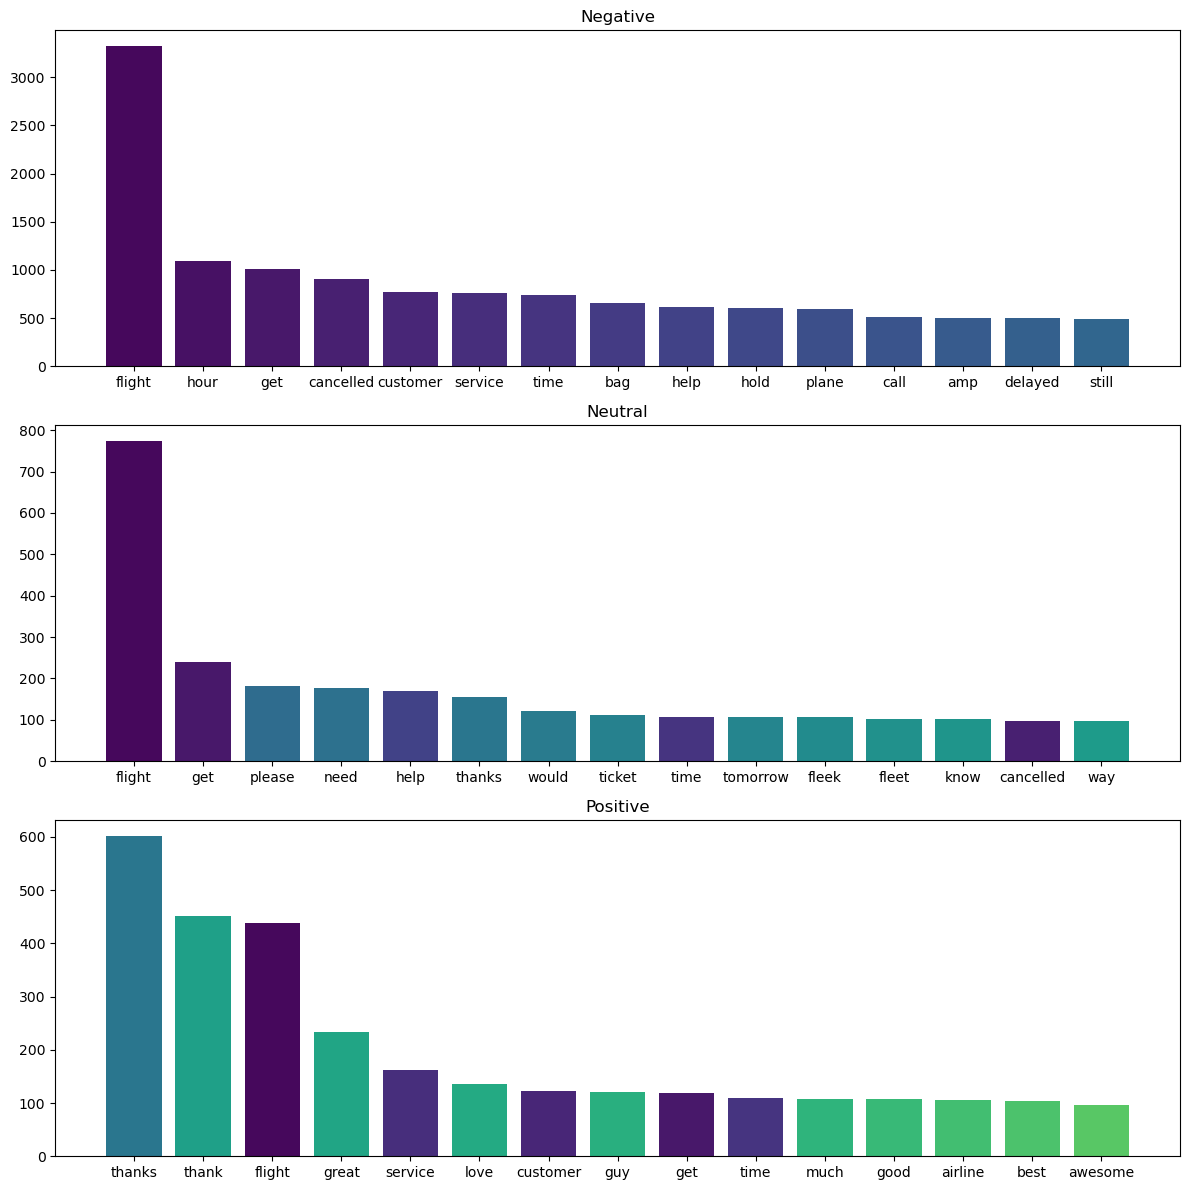

In [33]:
# bar graphs showing the top 15 words in each sentiment category
fig, axes = plt.subplots(nrows=3, figsize=(12, 12))
copy_df['tokenized_text'] = copy_df['preprocessed_text'].apply(lambda x: tokenizer.tokenize(x)) 

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('viridis', n_colors=45)

# Creating a plot for each unique sentiment category
data_by_sentiment = [y for _, y in copy_df.groupby('airline_sentiment', as_index=False)]
for idx, sentiment_df in enumerate(data_by_sentiment):
    # Find top 15 words in this sentiment category
    all_words_in_sentiment = sentiment_df.tokenized_text.explode()
    top_15 = all_words_in_sentiment.value_counts()[:15]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_15.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_15.index, top_15.values, color=colors)
    ax.set_title(sentiment_df.iloc[0].airline_sentiment.title())
    
fig.tight_layout()

Common words in the tweets with negative sentiments: hour, cancelled, customer, service, time, delayed <br>
Common words in the tweets with positive sentiments: thanks, great, service, customer, time

### Train, test and validation splits

In [34]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(copy_df['preprocessed_text'], copy_df['airline_sentiment'], random_state=42)
X_train.head()

1147    shes international phone fritz get chicago nea...
9438    row flight 634 today youre looking specific ru...
9761    call find booked tomorrow ask number email day...
8368    trying charge 550 dollar cash ticket paid mont...
3289     able get moon flight got hotel puerto rico thank
Name: preprocessed_text, dtype: object

In [35]:
# Split the data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, random_state=42)
X_train_final.shape

(8157,)

### One-hot encoding the texts

The text should be transformed into sequences of integers instead of a matrix of vectors for the neural network to use an embedding layer, which maps each word to a vector to capture semantic meaning. The embedding layer only works with integer sequences, so using integer sequences as input is recommended.

In [23]:
# Tokenize the text and convert it to sequences of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_final)
X_train_seq = tokenizer.texts_to_sequences(X_train_final)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### Encoding Categorical Labels 

Transform the descriptive labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels. 

In [24]:
# Transform the sentiment labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train_final)
y_train_lb = to_categorical(lb.transform(y_train_final))[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

### Padding the sequences to a fixed length

Since words can have varying lengths, it's necessary to pad the sequences to a fixed length so that they can be fed into a neural network. Padding involves adding zeros to the end of the sequences so that all sequences have the same length. The fixed length of the sequences is typically determined by the maximum length of the input sequence in the dataset. It's important to choose a length that's long enough to capture the majority of the information in the sequences, but not so long that it leads to unnecessary computational overhead or memory usage. <br>
Padding allows us to efficiently process data, capture contextual information, and improve the performance of the neural network.

In [25]:
# Pad the sequences to a fixed length
max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Modeling

## Textblob

TextBlob is a Python library with methods for calculating the subjectivity and polarity of text, such as tweets. Subjectivity measures how much of a personal opinion or judgment is expressed, while polarity measures the sentiment conveyed in the text, with values between -1 and 1 indicating negative, neutral, or positive sentiment. These values can be used to classify tweets as negative, positive, or neutral, with values above 0 being positive, below 0 being negative, and exactly 0 being neutral.

In [26]:
#calculating subjectivity and polarity scores
copy_df['Subjectivity'] = copy_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
copy_df['Polarity'] = copy_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
copy_df['sentiment_textblob'] = copy_df['Polarity'].apply(lambda x: 'positive' if x > 0 else (
                                'negative' if x < 0 else 'neutral'))

copy_df.head(3)

,airline,retweet_count,text,name,tweet_created,airline_sentiment,cleaned_text,preprocessed_text,Subjectivity,Polarity,sentiment_textblob
0,Virgin America,0,@VirginAmerica What @dhepburn said.,cairdin,2015-02-24 11:35:52-08:00,neutral,What said.,said,0.0000,0.000000,neutral
1,Virgin America,0,@VirginAmerica plus you've added commercials t...,jnardino,2015-02-24 11:15:59-08:00,positive,plus youve added commercials to the experienc...,plus youve added commercial experience ... tacky,0.0000,0.000000,neutral
2,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,yvonnalynn,2015-02-24 11:15:48-08:00,neutral,I didnt today... Must mean I need to take ano...,didnt today ... must mean need take another trip,0.6875,-0.390625,negative


neutral     5442
positive    5427
negative    3634
Name: sentiment_textblob, dtype: int64


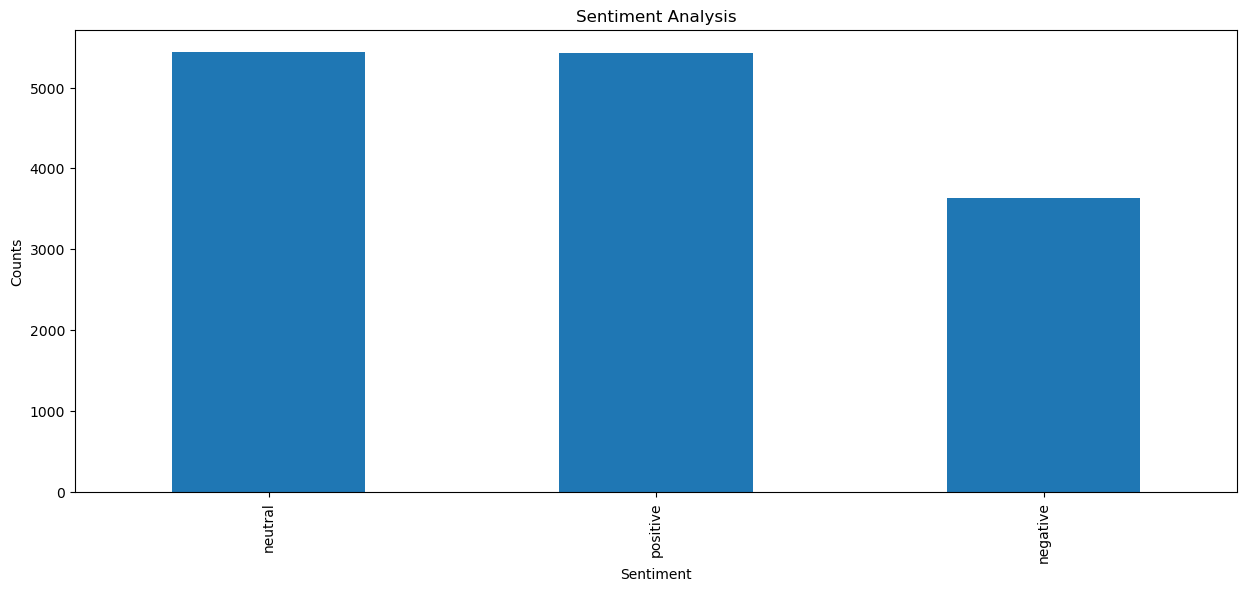

In [27]:
# Show the value counts
print(copy_df['sentiment_textblob'].value_counts())

# bar plot showing the sentiment categories
plt.subplots(figsize= (11, 5))
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
copy_df['sentiment_textblob'].value_counts().plot(kind='bar')
plt.show()

In [28]:
# function to display recall and f1_score values i pandas dataframe(textblob and vader) 
eval_df = pd.DataFrame()
def evaluate_sentiments(eval_df, model, predicted_sentiment_col):
    f1 = f1_score(copy_df['airline_sentiment'], copy_df[predicted_sentiment_col], average='weighted')
    recall = recall_score(copy_df['airline_sentiment'], copy_df[predicted_sentiment_col], average='weighted')
    new_row = {'Model': model, 'recall': round(recall, 3), 'f1_score': round(f1, 3)}
    new_df = pd.DataFrame(new_row, index=[len(eval_df)])
    eval_df = pd.concat([eval_df, new_df], ignore_index=True)
    return eval_df

In [29]:
# recall and f1_score in a dataframe
eval_df = evaluate_sentiments(eval_df, 'Textblob', 'sentiment_textblob')
eval_df

,Model,recall,f1_score
0,Textblob,0.465,0.477


## VADER sentiment analyzer

In [30]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Add sentiment category to existing dataframe
copy_df['sentiment_vader'] = copy_df['preprocessed_text'].apply(
                            lambda x: 'positive' if sia.polarity_scores(x)['compound'] > 0 else 
                            ('negative' if sia.polarity_scores(x)['compound'] < 0 else 'neutral'))
copy_df['sentiment_score_vader'] = copy_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
copy_df.head(3)

,airline,retweet_count,text,name,tweet_created,airline_sentiment,cleaned_text,preprocessed_text,Subjectivity,Polarity,sentiment_textblob,sentiment_vader,sentiment_score_vader
0,Virgin America,0,@VirginAmerica What @dhepburn said.,cairdin,2015-02-24 11:35:52-08:00,neutral,What said.,said,0.0000,0.000000,neutral,neutral,0.0
1,Virgin America,0,@VirginAmerica plus you've added commercials t...,jnardino,2015-02-24 11:15:59-08:00,positive,plus youve added commercials to the experienc...,plus youve added commercial experience ... tacky,0.0000,0.000000,neutral,neutral,0.0
2,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,yvonnalynn,2015-02-24 11:15:48-08:00,neutral,I didnt today... Must mean I need to take ano...,didnt today ... must mean need take another trip,0.6875,-0.390625,negative,neutral,0.0


In [31]:
# recall and f1_score in a dataframe
eval_df = evaluate_sentiments(eval_df, 'Vader', 'sentiment_vader')
eval_df

,Model,recall,f1_score
0,Textblob,0.465,0.477
1,Vader,0.511,0.533


## Recurrent Neural Network(RNN)

### Simple RNN

The embedding layer allows the model to learn a continuous and dense representation of words that can capture the semantic relationships between them. This is in contrast to sparse representations such as CountVectorizer, which can be less effective in capturing these relationships due to their high dimensionality and lack of continuity.

In [32]:
# ensure that the results are reproducible
random.seed(123)

#metrics : recall and custom function f1_score
recall = tensorflow.keras.metrics.Recall()
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [33]:
# Define the model architecture
baseline_model = Sequential()
baseline_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
baseline_model.add(SimpleRNN(128, activation='relu'))
baseline_model.add(Dense(64, activation='relu'))
baseline_model.add(Dense(3, activation='softmax'))

# Compile the model
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[recall, f1_score])

# Train the model
baseline_history = baseline_model.fit(X_train_padded, y_train_lb, epochs=20, batch_size=32, validation_data=(X_val_padded, y_val_lb))

Epoch 1/20
255/255 [==============================] - 10s 31ms/step - loss: 0.8098 - recall: 0.5397 - f1_score: 0.6091 - val_loss: 0.6878 - val_recall: 0.5419 - val_f1_score: 0.6559
Epoch 2/20
255/255 [==============================] - 8s 31ms/step - loss: 0.6197 - recall: 0.5751 - f1_score: 0.6825 - val_loss: 0.6943 - val_recall: 0.5757 - val_f1_score: 0.6695
Epoch 3/20
255/255 [==============================] - 8s 30ms/step - loss: 0.5234 - recall: 0.6060 - f1_score: 0.7106 - val_loss: 0.7734 - val_recall: 0.5596 - val_f1_score: 0.6669
Epoch 4/20
255/255 [==============================] - 8s 30ms/step - loss: 0.4574 - recall: 0.6018 - f1_score: 0.7243 - val_loss: 0.7311 - val_recall: 0.6346 - val_f1_score: 0.6757
Epoch 5/20
255/255 [==============================] - 8s 31ms/step - loss: 0.4118 - recall: 0.7419 - f1_score: 0.7768 - val_loss: 0.9961 - val_recall: 0.5346 - val_f1_score: 0.6481
Epoch 6/20
255/255 [==============================] - 8s 31ms/step - loss: 0.3852 - recall: 0.

In [34]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = baseline_history.history
baseline_model_val_dict.keys()

dict_keys(['loss', 'recall', 'f1_score', 'val_loss', 'val_recall', 'val_f1_score'])

In [35]:
# Fuction to plot loss and metrics vs number of epochs with train and validation sets
def visualize_training_results(results):
    history = results.history
    
    # create two axis objects side by side
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    
    # plot loss on the first axis
    ax1.plot(history['val_loss'])
    ax1.plot(history['loss'])
    ax1.legend(['val_loss', 'loss'], loc='upper left', fontsize=9)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # plot recall and f1 score metrics on the second axis
    ax2.plot(history['val_recall'])
    ax2.plot(history['val_f1_score'])
    ax2.plot(history['recall'])
    ax2.plot(history['f1_score'])
    ax2.legend(['val_recall', 'val_f1_score','recall', 'f1_score'], loc='upper left', fontsize=9)
    ax2.set_title('Recall and F1 score metrics')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Evaluation metrics')
    
    # display the plots
    plt.show()  

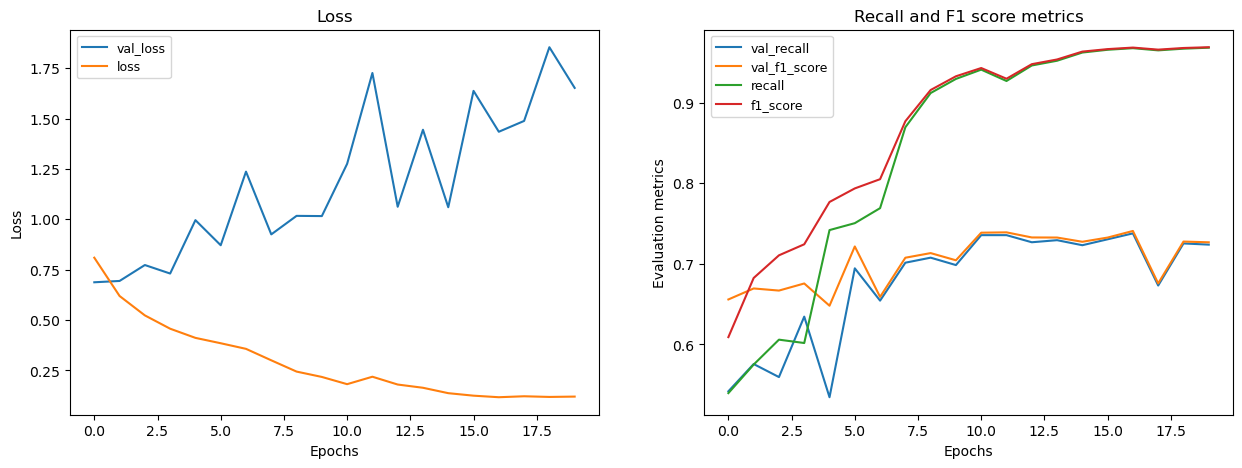

In [36]:
# call function to visualize loss and metrics
visualize_training_results(baseline_history)

In [37]:
# function to evaluate RNN models
def evaluate(eval_df, model, model_name):
    results_test = model.evaluate(X_test_padded, y_test_lb)
    new_row = {'Model': model_name, 'recall': round(results_test[1], 3), 
               'f1_score': round(results_test[2], 3), 'Loss': round(results_test[0], 3)}
    new_df = pd.DataFrame(new_row, index=[len(eval_df)])
    eval_df = pd.concat([eval_df, new_df], ignore_index=True)
    return eval_df

In [38]:
# call function to evaluate the model
eval_df = evaluate(eval_df, baseline_model, 'Simple RNN')
eval_df

114/114 [==============================] - 2s 7ms/step - loss: 1.5304 - recall: 0.7206 - f1_score: 0.7224


,Model,recall,f1_score,Loss
0,Textblob,0.465,0.477,NaN
1,Vader,0.511,0.533,NaN
2,Simple RNN,0.721,0.722,1.53


### LSTM

In [39]:
# Define the model architecture
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
lstm_model.add(LSTM(128, activation='relu'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(3, activation='softmax'))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[recall, f1_score])

# Train the model
lstm_history = lstm_model.fit(X_train_padded, y_train_lb, epochs=20, batch_size=32, validation_data=(X_val_padded, y_val_lb))

Epoch 1/20
255/255 [==============================] - 20s 66ms/step - loss: 0.7911 - recall: 0.5727 - f1_score: 0.5858 - val_loss: 0.8682 - val_recall: 0.6482 - val_f1_score: 0.7010
Epoch 2/20
255/255 [==============================] - 13s 51ms/step - loss: 0.5479 - recall: 0.6352 - f1_score: 0.7223 - val_loss: 0.6515 - val_recall: 0.6945 - val_f1_score: 0.7308
Epoch 3/20
255/255 [==============================] - 16s 62ms/step - loss: 0.4472 - recall: 0.7951 - f1_score: 0.8136 - val_loss: 0.6663 - val_recall: 0.6529 - val_f1_score: 0.7056
Epoch 4/20
255/255 [==============================] - 16s 62ms/step - loss: 0.3441 - recall: 0.8647 - f1_score: 0.8734 - val_loss: 0.7548 - val_recall: 0.7268 - val_f1_score: 0.7310
Epoch 5/20
255/255 [==============================] - 17s 67ms/step - loss: 0.2714 - recall: 0.9058 - f1_score: 0.9086 - val_loss: 0.8656 - val_recall: 0.7493 - val_f1_score: 0.7514
Epoch 6/20
255/255 [==============================] - 18s 70ms/step - loss: 0.2101 - recal

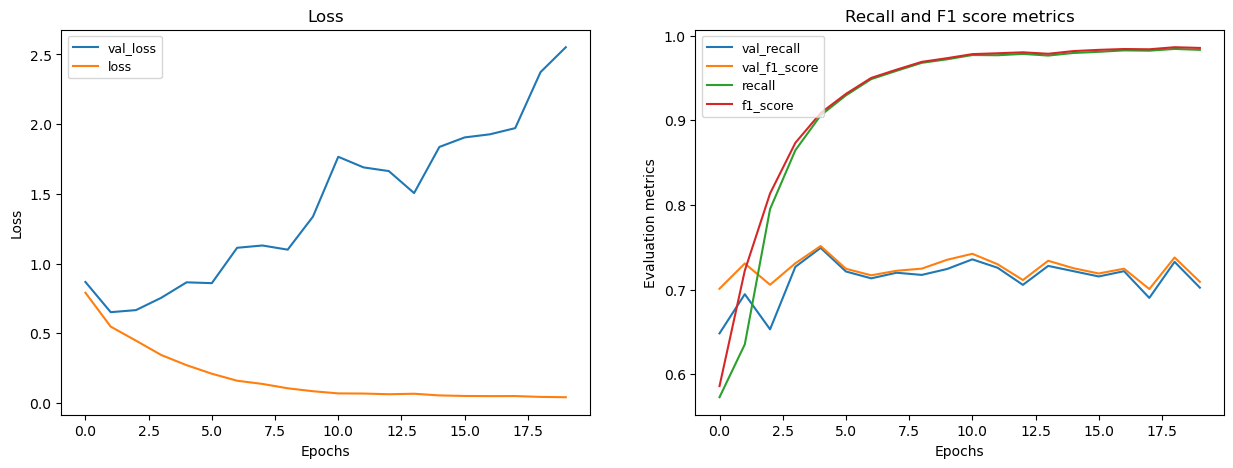

In [40]:
# call function to visualize loss and metrics
visualize_training_results(lstm_history)

In [41]:
# call function to evaluate the model
eval_df = evaluate(eval_df, lstm_model, 'LSTM')
eval_df

114/114 [==============================] - 2s 14ms/step - loss: 2.2379 - recall: 0.7030 - f1_score: 0.7095


,Model,recall,f1_score,Loss
0,Textblob,0.465,0.477,NaN
1,Vader,0.511,0.533,NaN
2,Simple RNN,0.721,0.722,1.530
3,LSTM,0.703,0.710,2.238


<b>Tuning Simple RNN using earlystop</b><br>
Early stopping is a technique used in machine learning to prevent overfitting of a model. It  involves monitoring the performance of the model on a validation dataset during the training process.<br>
If the performance of the model on the validation dataset begins to degrade or plateau while the performance on the training dataset continues to improve, then the training process is stopped early before the model begins to overfit

In [42]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=3), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# Train the model
baseline_ES_history = baseline_model.fit(X_train_padded, y_train_lb, epochs=20, batch_size=32,callbacks=early_stopping, validation_data=(X_val_padded, y_val_lb))

Epoch 1/20
255/255 [==============================] - 9s 36ms/step - loss: 0.1803 - recall: 0.9503 - f1_score: 0.9515 - val_loss: 1.6438 - val_recall: 0.7235 - val_f1_score: 0.7263
Epoch 2/20
255/255 [==============================] - 8s 33ms/step - loss: 0.1603 - recall: 0.9575 - f1_score: 0.9581 - val_loss: 2.6388 - val_recall: 0.7114 - val_f1_score: 0.7119
Epoch 3/20
255/255 [==============================] - 10s 38ms/step - loss: 0.1322 - recall: 0.9647 - f1_score: 0.9655 - val_loss: 1.2284 - val_recall: 0.6982 - val_f1_score: 0.6987
Epoch 4/20
255/255 [==============================] - 9s 37ms/step - loss: 0.1129 - recall: 0.9709 - f1_score: 0.9711 - val_loss: 1.7920 - val_recall: 0.7110 - val_f1_score: 0.7120
Epoch 5/20
255/255 [==============================] - 8s 31ms/step - loss: 0.1358 - recall: 0.9629 - f1_score: 0.9632 - val_loss: 1.5496 - val_recall: 0.7077 - val_f1_score: 0.7080
Epoch 6/20
255/255 [==============================] - 9s 35ms/step - loss: 0.1713 - recall: 0.

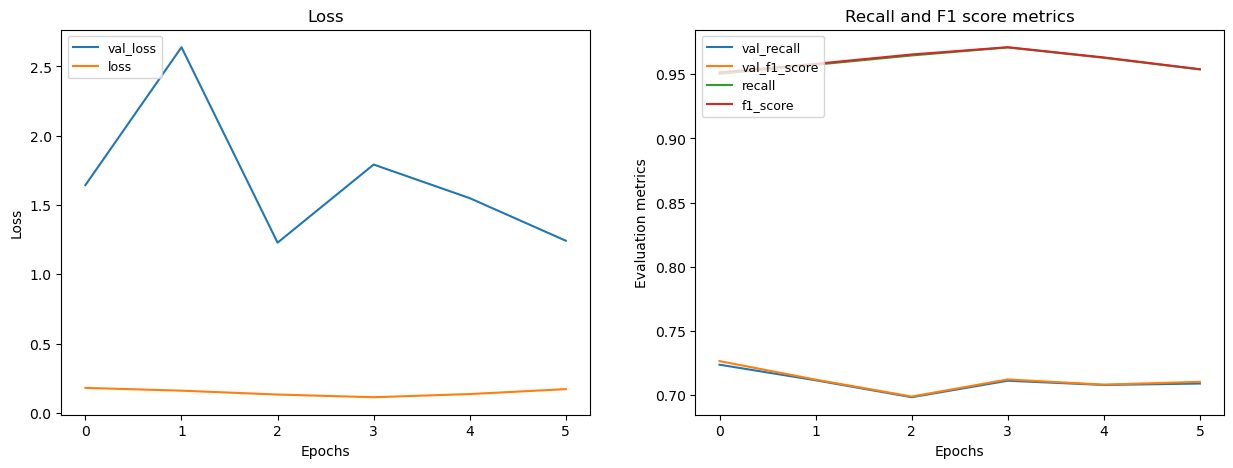

In [43]:
# call function to visualize loss and metrics
visualize_training_results(baseline_ES_history)

<b>Tuning Simple RNN using earlystop and Dropout</b><br>
A dropout layer is a layer in a neural network that randomly sets a fraction of the input units to zero during each training epoch. During the training process, dropout helps to reduce the dependence of the network on any single input feature, and forces the network to learn more robust features that are useful for making predictions on new data. The result is a more generalizable model that is less likely to overfit to the training data.



In [44]:
# Define the model architecture
baseline_drop_model = Sequential()
baseline_drop_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
baseline_drop_model.add(Dropout(0.35))   # Add a dropout layer with a drop probability of 0.5
baseline_drop_model.add(SimpleRNN(128, activation='relu'))
baseline_drop_model.add(Dropout(0.35))   # Add another dropout layer with a drop probability of 0.5
baseline_drop_model.add(Dense(64, activation='relu'))
baseline_drop_model.add(Dense(3, activation='softmax'))

# Compile the model
baseline_drop_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=[recall, f1_score])

# Train the model
baseline_drop_history = baseline_drop_model.fit(X_train_padded, y_train_lb, epochs=100, batch_size=32, callbacks=early_stopping, validation_data=(X_val_padded, y_val_lb))

Epoch 1/100
255/255 [==============================] - 8s 26ms/step - loss: 0.9593 - recall: 0.4780 - f1_score: 0.4123 - val_loss: 0.9182 - val_recall: 0.6246 - val_f1_score: 0.6246
Epoch 2/100
255/255 [==============================] - 6s 24ms/step - loss: 0.9241 - recall: 0.6224 - f1_score: 0.6225 - val_loss: 0.9180 - val_recall: 0.6246 - val_f1_score: 0.6246
Epoch 3/100
255/255 [==============================] - 6s 25ms/step - loss: 0.9230 - recall: 0.6225 - f1_score: 0.6225 - val_loss: 0.9169 - val_recall: 0.6246 - val_f1_score: 0.6246
Epoch 4/100
255/255 [==============================] - 7s 26ms/step - loss: 0.9209 - recall: 0.6225 - f1_score: 0.6225 - val_loss: 0.9161 - val_recall: 0.6246 - val_f1_score: 0.6246
Epoch 5/100
255/255 [==============================] - 6s 23ms/step - loss: 0.9193 - recall: 0.6225 - f1_score: 0.6225 - val_loss: 0.9111 - val_recall: 0.6246 - val_f1_score: 0.6246
Epoch 6/100
255/255 [==============================] - 5s 21ms/step - loss: 0.9045 - recal

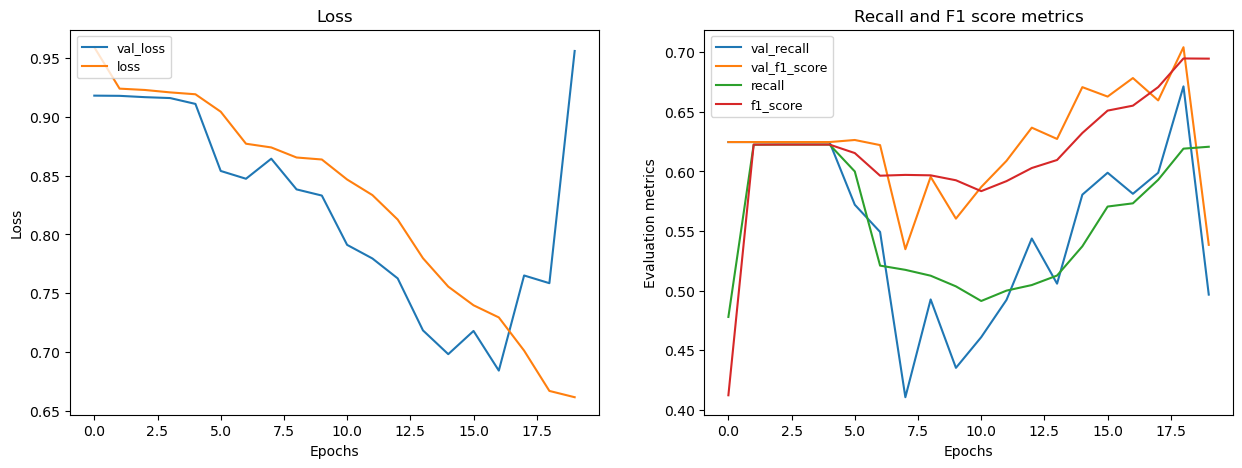

In [45]:
# call function to visualize loss and metrics
visualize_training_results(baseline_drop_history)